# **Setup**

In [8]:
import rspredict.data.datarequester as rspred

In [9]:
# Set up data request
rsd = rspred.RSDataRequester()
rsd.set_game_base("rs")
rsd.set_data_filter("all")
rsd.show_debug = True
rsd.integrate_social = False

In [13]:
import requests # use to retrieve data from API
import math
import pandas as pd
import datetime as datetime
import tensorflow as tf
# from tf import timeseries_dataset_from_array
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# **Get data**

In [14]:
#ge_ts_prices = rsd.get_time_series_historical_prices(indiv_item_ids = [48926, 48211])
ge_ts_prices = rsd.get_time_series_historical_prices(indiv_item_ids = [48926, 48211])

# normalize dates
#ge_ts_prices["date"] = ge_ts_prices["date"].apply(lambda x: x.replace(hour = 0, minute = 0, second=0, microsecond=0))
display(ge_ts_prices)

Status of item 48211: 200
Status of item 48926: 200


,id,price,date
0,48211,9000,2019-01-12 00:00:00+00:00
1,48211,9000,2019-01-13 00:00:00+00:00
2,48211,9000,2019-01-14 00:00:00+00:00
3,48211,9000,2019-01-15 00:00:00+00:00
4,48211,9000,2019-01-16 00:00:00+00:00
...,...,...,...
4033,48926,12744,2024-10-14 12:25:16+00:00
4034,48926,12848,2024-10-15 11:21:38+00:00
4035,48926,12700,2024-10-16 07:36:37+00:00
4036,48926,12746,2024-10-17 02:43:59+00:00


# **Prepare dataset**

This modeling work is based on work done by Kavya Malla to implement multiple time series.
* [Tensorflow tf.data Pipeline for Multiple Time Series](https://medium.com/@kavyamalla/extending-tensorflows-window-generator-for-multiple-time-series-8b15eba57858)
* [medium_posts/WindowGenerator_with_Multiple_Time_Series.ipynb](https://github.com/kavya006/medium_posts/blob/main/WindowGenerator_with_Multiple_Time_Series.ipynb)

In [15]:
# Model settings for time series.
LABELS = ["price"] # targets to predict
FEATURES = ["price"] # variables used to predict
TIMECOMP = "date" # column for time component
IN_STEPS = 30 # timepoints used to predict
OUT_STEPS = 30  # timepoints to predict out
GROUPBY = ['id'] # column used to specify time series by
BATCH_SIZE = 8 

TRAIN_VAL_TEST_RATIO = (0.7, 0.2, 0.1)
total_ratio = sum([x for x in TRAIN_VAL_TEST_RATIO])
final_train_val_test_ratio = tuple([x / total_ratio for x in TRAIN_VAL_TEST_RATIO])
print(final_train_val_test_ratio)

(0.7, 0.2, 0.1)


In [16]:
# Create train, validation, and test datasets

# Get dataset count and proportions for spliting dataset into training, validation, and test datasets
n = len(ge_ts_prices) 
train_val_r = final_train_val_test_ratio[0]
val_test_r = final_train_val_test_ratio[0] + final_train_val_test_ratio[1]

def get_iloc(n, ratio):
    return int(len(n) * ratio)

# Split using groupby (to split each item specific data) and iloc (split item specific records into train, val, test)
train_series = ge_ts_prices.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[:get_iloc(x, train_val_r)]).reset_index(drop=True)
val_series = ge_ts_prices.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[get_iloc(x, train_val_r):get_iloc(x, val_test_r)]).reset_index(drop=True)
test_series = ge_ts_prices.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[get_iloc(x, val_test_r):]).reset_index(drop=True)

print(f"""Shape summary:
      Train shape: {train_series.shape}
      Val shape: {val_series.shape}
      Test shape: {test_series.shape}""")

record_count = train_series.shape[0]+ val_series.shape[0]+ test_series.shape[0]
if len(ge_ts_prices) == record_count:
    print("All records accounted for.")
else:
    print(f"{abs(len(ge_ts_prices) - record_count)} difference between split and original dataset.")

Shape summary:
      Train shape: (2826, 3)
      Val shape: (808, 3)
      Test shape: (404, 3)
All records accounted for.


C:\Users\yangs\AppData\Local\Temp\ipykernel_14308\1847253974.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_series = ge_ts_prices.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[:get_iloc(x, train_val_r)]).reset_index(drop=True)
C:\Users\yangs\AppData\Local\Temp\ipykernel_14308\1847253974.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_series = ge_ts_prices.groupby(GROUPBY, as_i

# **Prepare Modeling**

In [10]:
class MultiSeriesWindowsGenerator():
  def __init__(self, input_width, label_width, steps, batch_size, time_col, labels=[], features=[], static_columns=[], GROUPBY=None):

    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = labels
    if len(labels) != 0:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(labels)}
    
    self.GROUPBY = GROUPBY 
    self.time_col = time_col
    self.regressor_columns = features
    self.static_columns = static_columns

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = steps

    self.total_window_size = input_width + steps

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Batch Size: {self.batch_size}',
        f'Label column name(s): {self.label_columns}',
        f'Additional Regressor column name(s): {self.regressor_columns}', 
        f'GROUPBY column(s): {self.GROUPBY}' 
        ])
  
  

In [11]:
def preprocess_dataset(self:MultiSeriesWindowsGenerator, data:pd.DataFrame):
    try:
      if np.vstack(data.index).shape[1] != 1:
        data = data.reset_index() 

      by = self.GROUPBY + [self.time_col]
      labels = self.label_columns + self.regressor_columns + self.static_columns
      data = data.set_index(by).unstack(-1)
      data = tf.stack([data[label] for label in labels], axis=-1)
      
      if data.ndim != 3:
          data = data[None, None, tf.newaxis]
    except Exception as e:
      print('Error while processing dataset', e)
    return data 

def get_training_mean_std(self:MultiSeriesWindowsGenerator, data:pd.DataFrame):
    self.GROUPBY + [self.time_col]
    return data 

def update_datasets(self:MultiSeriesWindowsGenerator, train_df:pd.DataFrame, val_df:pd.DataFrame, test_df:pd.DataFrame, norm:bool=False):
    # Store the raw data.
    self.train_df = self.preprocess_dataset(train_df)
    self.val_df = self.preprocess_dataset(val_df)
    self.test_df = self.preprocess_dataset(test_df)

    if norm: # If we want to normalize the data:
      # Get mean and std for normalization
      train_mean = tf.convert_to_tensor(np.nanmean(self.train_df.numpy(), axis = 1, keepdims = 1))
      train_std = tf.convert_to_tensor(np.nanstd(self.train_df.numpy(), axis = 1, keepdims = 1))

      # Create final training/validation/test tensors
      self.train_df = (self.train_df - train_mean) / train_std
      self.val_df = (self.val_df - train_mean) / train_std
      self.test_df = (self.test_df - train_mean) / train_std

      # Retain normalization info for potential denormalization.
      self.train_mean = train_mean 
      self.train_std = train_std 
      self.norm = norm 

    labels = self.label_columns + self.regressor_columns + self.static_columns
    self.column_indices = {name: i for i, name in enumerate(labels)}

MultiSeriesWindowsGenerator.preprocess_dataset = preprocess_dataset 
MultiSeriesWindowsGenerator.update_datasets = update_datasets

In [12]:
w1 = MultiSeriesWindowsGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, steps=OUT_STEPS, 
                                 batch_size=BATCH_SIZE, time_col = TIMECOMP, 
                                 labels=LABELS, GROUPBY=GROUPBY, features=FEATURES)
w1.update_datasets(train_series, val_series, test_series, norm=True)

Error while processing dataset "None of ['date'] are in the columns"
Error while processing dataset "None of ['date'] are in the columns"
Error while processing dataset "None of ['date'] are in the columns"


AttributeError: 'DataFrame' object has no attribute 'numpy'

In [299]:
def split_window(self, features:tf.Tensor):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    # additional check for when the label columns = regressor columns
    if self.label_columns is not None and len(set(self.label_columns + self.regressor_columns)) != 1: 
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] 
          for name in self.label_columns], axis=-1)
          
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels 
MultiSeriesWindowsGenerator.split_window = split_window

In [301]:
example_window = tf.stack([
    np.array(train_series.set_index(GROUPBY + [TIMECOMP])[:w1.total_window_size]), 
    np.array(train_series.set_index(GROUPBY + [TIMECOMP])[2:2+w1.total_window_size]),
    np.array(train_series.set_index(GROUPBY + [TIMECOMP])[4:4+w1.total_window_size])
])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 60, 1)
Inputs shape: (3, 30, 1)
Labels shape: (3, 30, 1)


In [319]:
w1.example = (example_inputs, example_labels)

def plot(self, model=None, plot_col=LABELS[0], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    # if len(set(self.label_columns + self.regressor_columns)) == 1:
    #   label_col_index = 0
    #   plot_col_index = 0
    if label_col_index is None:
      continue
    
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index-1],
             label='Inputs', marker='.', zorder=-10)   

    plt.scatter(self.label_indices, labels[n, :, label_col_index-1],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index-1],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [MS]')

MultiSeriesWindowsGenerator.plot = plot

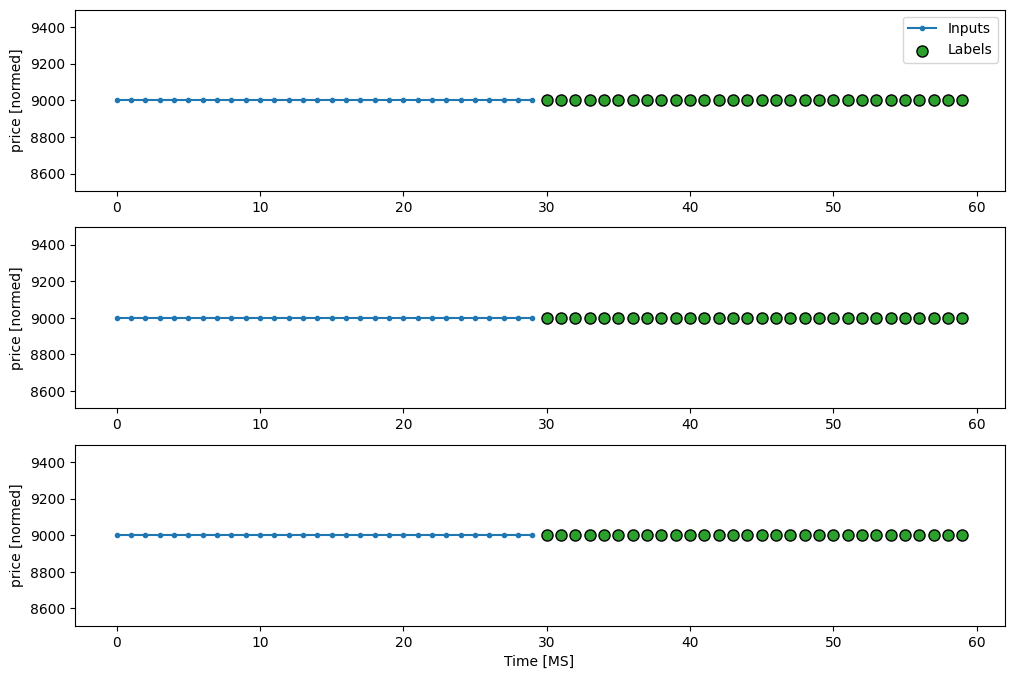

In [320]:
w1.plot()

In [322]:
def make_cohort(self, data:np.array) -> tf.data.Dataset:
    data = np.array(data, dtype=np.float32) 
    ds = timeseries_dataset_from_array(
        data=data, 
        targets=None, 
        sequence_length=self.total_window_size, 
        sequence_stride=1, 
        shuffle=True, 
        batch_size=self.batch_size
    )
    ds = ds.map(self.split_window) 
    return ds 

MultiSeriesWindowsGenerator.make_cohort = make_cohort

In [323]:
w1.make_cohort(train_series.set_index(GROUPBY + [TIMECOMP]))

<_MapDataset element_spec=(TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>

In [324]:
"""
From Kavya: Reference code from https://stackoverflow.com/questions/49994496/mixing-multiple-tf-data-dataset
"""

def stack_windows(*windows):
    features = tf.concat([window[0] for window in windows], 0) 
    labels = tf.concat([window[1] for window in windows], 0) 
    return (features, labels)
    
def make_dataset(self, data:tf.Tensor) -> tf.data.Dataset:    
    # num_cohorts = min(10, len(cluster_cohorts))
    # print(cluster, num_cohorts)
    ds_list = tuple(self.make_cohort(data[i]) for i in range(len(data)))
    ds = tf.data.Dataset.zip(ds_list)
    ds = ds.map(stack_windows)
    ds = ds.unbatch() 
    ds = ds.shuffle(10, seed=0)
    ds = ds.batch(self.batch_size) 
    ds = ds.prefetch(1)
    return ds 

MultiSeriesWindowsGenerator.make_dataset = make_dataset


In [349]:
w1.train_df

<tf.Tensor: shape=(2, 1500, 2), dtype=float64, numpy=
array([[[-1.09483641, -1.09483641],
        [-1.09483641, -1.09483641],
        [-1.09483641, -1.09483641],
        ...,
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]],

       [[        nan,         nan],
        [        nan,         nan],
        [        nan,         nan],
        ...,
        [ 0.72214183,  0.72214183],
        [ 0.67432671,  0.67432671],
        [ 0.59239   ,  0.59239   ]]])>

In [325]:
w1.make_dataset(w1.train_df)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None))>

In [326]:
@property
def train(self) -> tf.data.Dataset:
    return self.make_dataset(self.train_df)

@property 
def val(self) -> tf.data.Dataset:
    return self.make_dataset(self.val_df)

@property 
def test(self) -> tf.data.Dataset:
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting"""
    result = getattr(self, '_example', None) 
    print('Number of train batches:', len(list(self.train.as_numpy_iterator())))
    if result is None: 
        result = next(iter(self.train)) 
        self._example = result 
    return result 

MultiSeriesWindowsGenerator.train = train 
MultiSeriesWindowsGenerator.test = test 
MultiSeriesWindowsGenerator.val = val 
MultiSeriesWindowsGenerator.example = example 

In [327]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 30, 2)
Labels shape (batch, time, features): (8, 30, 2)


Number of train batches: 361


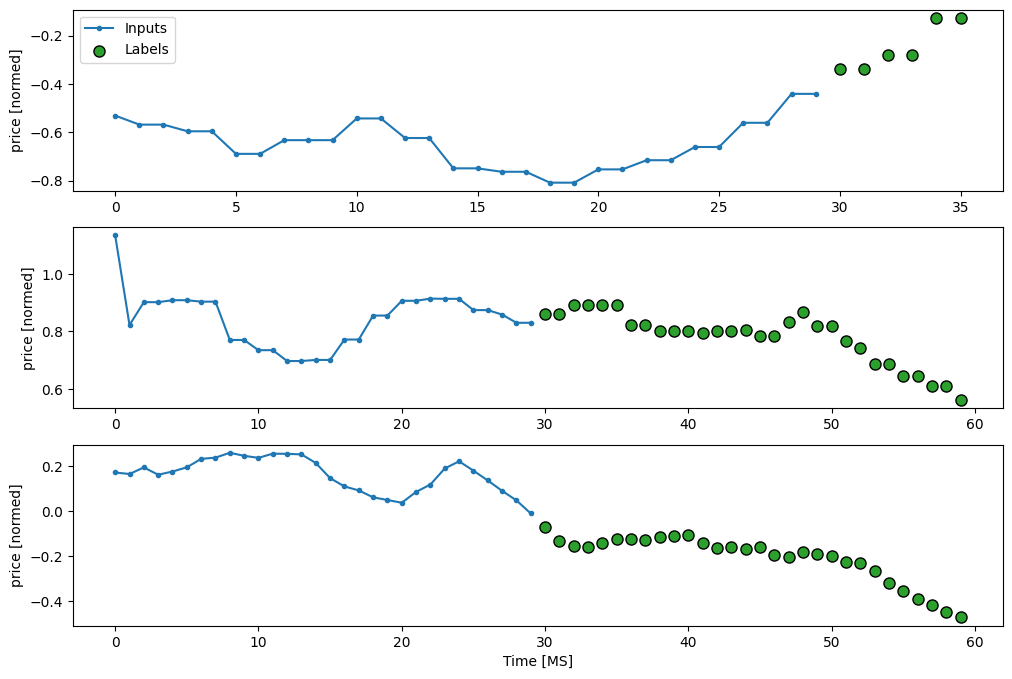

In [328]:
w1.plot()

# **Model Baseline**

In [346]:
single_step_window = MultiSeriesWindowsGenerator(
    input_width=1, label_width=1, steps=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY, labels=LABELS, features=FEATURES, time_col= TIMECOMP)
single_step_window.update_datasets(train_series, val_series, test_series, norm=True)

In [347]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]
     

In [348]:
single_step_window.train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None))>

In [336]:
baseline = Baseline(label_index=single_step_window.column_indices[LABELS[0]])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - mean_absolute_error: nan


C:\Users\yangs\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [339]:
wide_window = MultiSeriesWindowsGenerator(
    input_width=24, label_width=24, steps=1, batch_size=BATCH_SIZE, GROUPBY = GROUPBY,
    labels=LABELS, features=FEATURES, time_col= TIMECOMP)
wide_window.update_datasets(train_series, val_series, test_series, norm=True)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Batch Size: 8
Label column name(s): ['price']
Additional Regressor column name(s): ['price']
GROUPBY column(s): ['id']

Number of train batches: 369


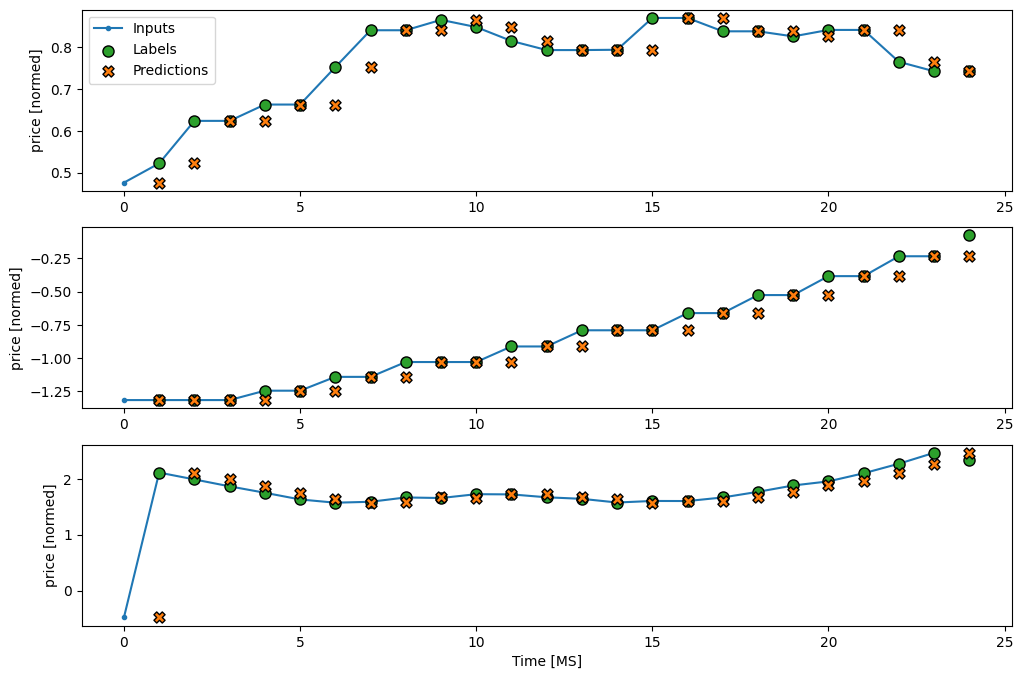

In [340]:
wide_window.plot(baseline)